<a href="https://colab.research.google.com/github/hanbo2000/NODEs---capstone/blob/main/Two-equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch   0  loss=36.004910  sigma=6.000  beta=1.500  rho=20.000
Epoch  50  loss=34.042763  sigma=6.372  beta=1.120  rho=20.499
Epoch 100  loss=38.765671  sigma=7.049  beta=1.124  rho=21.000
Epoch 150  loss=37.752560  sigma=7.335  beta=1.283  rho=21.504
Epoch 200  loss=37.307938  sigma=7.378  beta=1.796  rho=21.993
Epoch 250  loss=28.627100  sigma=7.163  beta=2.743  rho=22.355
Epoch 300  loss=23.346451  sigma=7.796  beta=3.355  rho=22.811
Epoch 350  loss=19.932230  sigma=8.902  beta=3.303  rho=23.336
Epoch 400  loss=17.503860  sigma=9.469  beta=3.235  rho=23.873
Epoch 450  loss=15.271186  sigma=9.760  beta=3.189  rho=24.404
Epoch 500  loss=12.584073  sigma=10.021  beta=3.087  rho=24.932
Epoch 550  loss=10.428972  sigma=10.299  beta=3.050  rho=25.457

Estimated parameters (vectorized RK4 + multiple shooting):
  sigma ≈ 10.4495
  beta  ≈ 2.9463
  rho   ≈ 25.9797


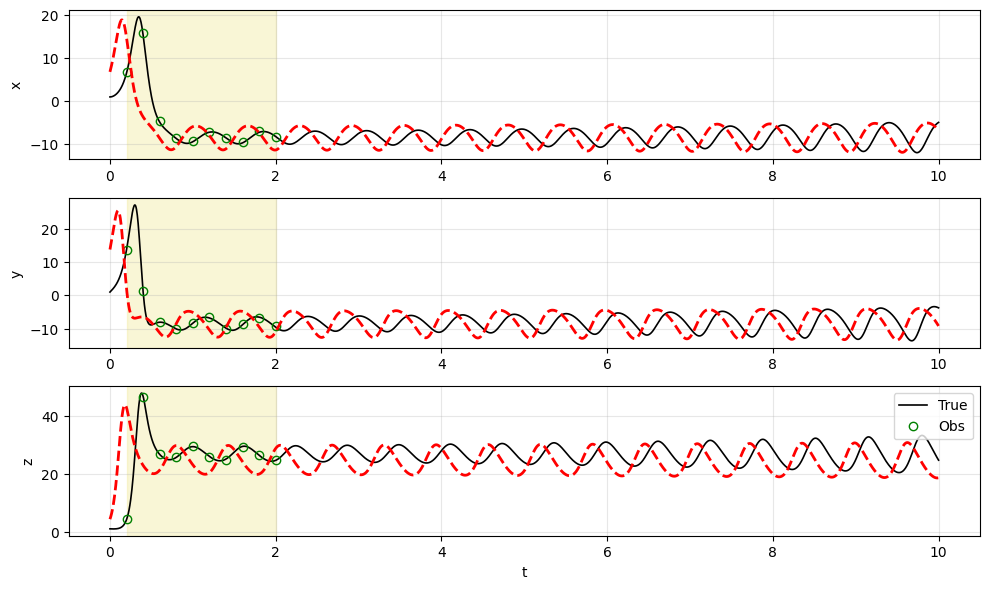

In [ ]:
# ==========================================================
# Lorenz-63 参数估计：向量化 RK4 + Multiple Shooting（PyTorch）
# 只用观测误差，不用真参数；无需 torchdiffeq
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------- 基本设置 ----------------
torch.set_default_dtype(torch.float32)      # float32 更快
torch.manual_seed(0); np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------- 造“真值”数据（仅用于对比，不进入训练损失） ----------------
def f_np(u, s, b, r):
    x, y, z = u
    return np.array([s*(y-x), x*(r-z)-y, x*y - b*z], float)

def rk4_np(f, u0, t, dt, *args):
    U = np.zeros((len(t), 3)); U[0] = u0; u = u0.copy()
    for i in range(len(t)-1):
        k1 = f(u, *args)
        k2 = f(u + 0.5*dt*k1, *args)
        k3 = f(u + 0.5*dt*k2, *args)
        k4 = f(u + dt*k3, *args)
        u  = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        U[i+1] = u
    return U

# 真参数（仅用于合成数据）
SIGMA_T, BETA_T, RHO_T = 10.0, 8.0/3.0, 28.0
DT, T_END = 0.005, 10.0
t_full = np.arange(0.0, T_END + 1e-12, DT)
u0_true = np.array([1., 1., 1.], dtype=float)
U_true = rk4_np(f_np, u0_true, t_full, DT, SIGMA_T, BETA_T, RHO_T)

# 观测：仅在 [0, T_assim] 内每 dt_m 采样，并加噪
T_assim, dt_m = 2.0, 0.2
obs_idx = np.linspace(int(dt_m/DT), int(T_assim/DT), int(T_assim/dt_m)).astype(int)
t_obs = t_full[obs_idx]
sig_m = 0.15
Y_obs = U_true[obs_idx] + np.random.normal(0.0, sig_m, size=(len(obs_idx), 3))

# ---------------- Torch 版动力学 ----------------
def f_torch(y, theta):
    """ y: (...,3); theta: (3,) = [sigma, beta, rho] """
    s, b, r = theta[0], theta[1], theta[2]
    x, y1, z = y[...,0], y[...,1], y[...,2]
    dx  = s * (y1 - x)
    dy  = x * (r - z) - y1
    dz  = x * y1 - b * z
    return torch.stack([dx, dy, dz], dim=-1)

# ---------------- 向量化 RK4（批量区间，步数不同用掩码） ----------------
def rk4_steps_batched(y0_batch, steps_batch, dt, theta):
    """
    y0_batch:    (B,3)  — 每个样本的起点（状态）
    steps_batch: (B,)    — 每个样本需要前进的细步数
    dt:          float   — 细步长（这里就是 DT）
    theta:       (3,)    — 当前参数
    返回 (B,3)：每个样本各自滚动到末端后的状态
    """
    B = y0_batch.shape[0]
    y  = y0_batch
    max_steps = int(steps_batch.max().item())
    for s in range(max_steps):
        active = (steps_batch > s).view(B, 1)             # 哪些样本还要前进一步
        k1 = f_torch(y, theta)
        k2 = f_torch(y + 0.5*dt*k1, theta)
        k3 = f_torch(y + 0.5*dt*k2, theta)
        k4 = f_torch(y + dt*k3, theta)
        y_next = y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y = torch.where(active, y_next, y)
    return y

# 单条整段 RK4（用于训练后自由预报/画图）
def rk4_full(y0, t_rel, theta):
    ys = [y0]
    y  = y0
    for i in range(len(t_rel)-1):
        dt = t_rel[i+1] - t_rel[i]
        k1 = f_torch(y, theta)
        k2 = f_torch(y + 0.5*dt*k1, theta)
        k3 = f_torch(y + 0.5*dt*k2, theta)
        k4 = f_torch(y + dt*k3, theta)
        y  = y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        ys.append(y)
    return torch.stack(ys, 0)

# ---------------- 待估参数模型 ----------------
def inv_softplus(x):
    x = torch.as_tensor(x, dtype=torch.get_default_dtype())
    return torch.log(torch.expm1(x))

class ParamNODE(nn.Module):
    def __init__(self):
        super().__init__()
        # 给一个更合理的初猜（不是用真值，只是更接近常见范围）
        self.raw = nn.Parameter(torch.stack([
            inv_softplus(6.0),   # sigma 初猜 ~ 6
            inv_softplus(1.5),   # beta  初猜 ~ 1.5
            inv_softplus(20.0),  # rho   初猜 ~ 20
        ]))
    def theta(self):
        return F.softplus(self.raw) + 1e-8

# ---------------- 数据张量（放到 device） ----------------
w_obs   = torch.tensor(Y_obs, dtype=torch.get_default_dtype(), device=device)   # (M,3)
t_rel   = torch.tensor(t_full - t_obs[0], dtype=torch.get_default_dtype(), device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], dtype=torch.long, device=device)
M = len(obs_idx)
n_sub = int(round(dt_m / DT))   # 每个观测间隔的细步数（常数）
assert n_sub >= 1

# ---------------- 向量化 Multiple Shooting 训练 ----------------
model = ParamNODE().to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)
loss_fn = nn.SmoothL1Loss(beta=0.5)
weight  = (1.0 / sig_m)

BATCH  = 1024       # 批量大 → 快 & 稳；GPU 可调更大
EPOCHS = 600
H_MAX  = 6          # 允许更长跨度（可配合课程学习）

for ep in range(EPOCHS):
    opt.zero_grad()

    # 采样一批起点和跨度（可加课程学习：H_curr = min(H_MAX, 1 + ep//100)）
    H_curr = min(H_MAX, 1 + ep // 100)
    k_batch = torch.randint(0, M-1, (BATCH,), device=device)
    h_batch = torch.randint(1, H_curr+1, (BATCH,), device=device)
    h_batch = torch.minimum(h_batch, (M-1 - k_batch))     # 防越界

    y0_batch    = w_obs[k_batch]                   # (B,3) 用观测作起点（去除了初值不确定性）
    y_tar_batch = w_obs[k_batch + h_batch]         # (B,3) 目标末端
    steps_batch = h_batch * n_sub                  # (B,)  每个样本需要的细步数

    theta = model.theta()                          # 只算一次
    y_pred = rk4_steps_batched(y0_batch, steps_batch, DT, theta)

    loss = loss_fn(y_pred * weight, y_tar_batch * weight)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 50 == 0:
        s, b, r = [t.item() for t in theta]
        print(f"Epoch {ep:3d}  loss={loss.item():.6f}  sigma={s:.3f}  beta={b:.3f}  rho={r:.3f}")

# ---------------- 训练后参数 & 整段自由预报 ----------------
with torch.no_grad():
    sigma_hat, beta_hat, rho_hat = model.theta().detach().cpu().numpy()
print("\nEstimated parameters (vectorized RK4 + multiple shooting):")
print(f"  sigma ≈ {sigma_hat:.4f}")
print(f"  beta  ≈ {beta_hat:.4f}")
print(f"  rho   ≈ {rho_hat:.4f}")

with torch.no_grad():
    y0 = torch.tensor(Y_obs[0], dtype=torch.get_default_dtype(), device=device)
    pred_full = rk4_full(y0, t_rel, model.theta()).cpu().numpy()

# ---------------- 画图 ----------------
plt.figure(figsize=(10,6))
names = ["x","y","z"]
for i in range(3):
    ax = plt.subplot(3,1,i+1)
    ax.plot(t_full, U_true[:,i], 'k-', lw=1.2, label="True")
    ax.plot(t_obs,  Y_obs[:,i],  'go', mfc="none", label="Obs")
    ax.plot(t_full, pred_full[:,i], 'r--', lw=2, label="Pred (vectorized RK4, θ̂)" if i==0 else None)
    ax.axvspan(t_obs[0], t_obs[-1], color='khaki', alpha=0.35)
    ax.set_ylabel(names[i]); ax.grid(True, alpha=0.3)
plt.xlabel("t"); plt.legend(loc="upper right"); plt.tight_layout(); plt.show()


Epoch    0 | Multi-shoot loss = 0.654981
Epoch  400 | Multi-shoot loss = 0.188269
Epoch  800 | Multi-shoot loss = 0.148260
Epoch 1200 | Multi-shoot loss = 0.112963
Epoch 1600 | Multi-shoot loss = 0.160390
Epoch 2000 | Multi-shoot loss = 0.086327


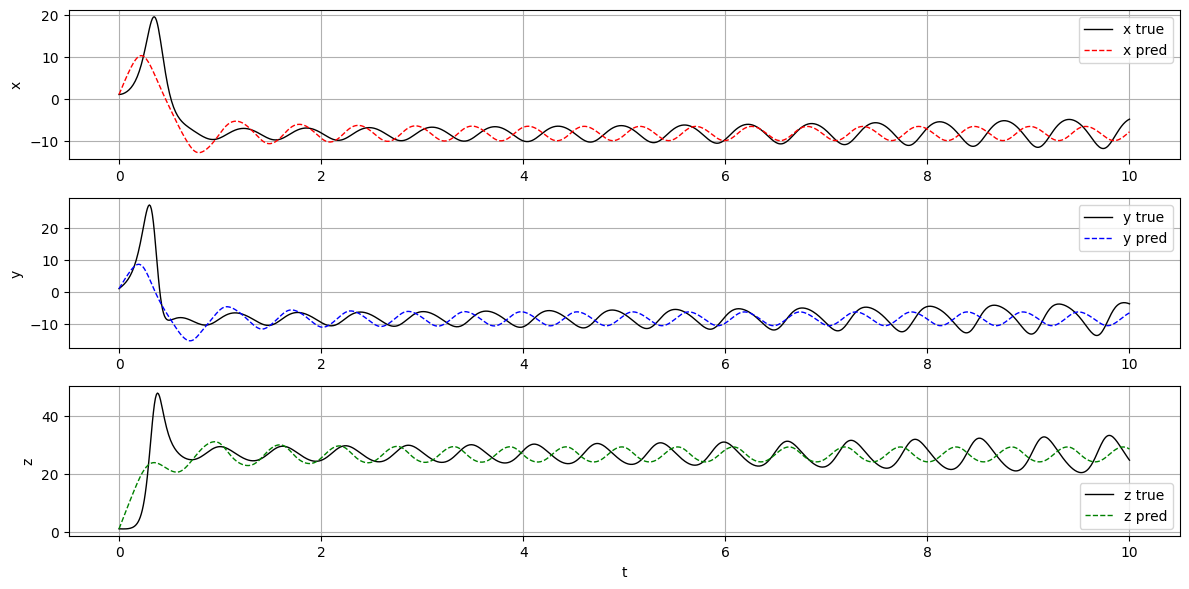

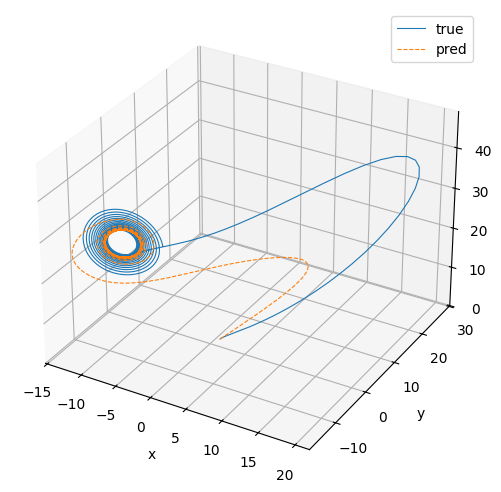

In [ ]:
# ===============================================
# NN 学习洛伦兹系统：标准化 + RK4 + 短窗口多起点 (Multi-Shooting)
# 可随意修改 T / dt
# ===============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

torch.manual_seed(0)
np.random.seed(0)

# -------------------------------
# 1) 生成数据（真洛伦兹 + 噪声）
# -------------------------------
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

def lorenz_true(u, t):
    x, y, z = u
    return np.array([
        sigma*(y-x),
        x*(rho-z) - y,
        x*y - beta*z
    ], dtype=np.float32)

def rk4_step_true(f, u, t, h):
    k1 = f(u, t)
    k2 = f(u + 0.5*h*k1, t + 0.5*h)
    k3 = f(u + 0.5*h*k2, t + 0.5*h)
    k4 = f(u + h*k3,     t + h)
    return u + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ---- 你可以自由修改 T, dt ----
T  = 10.0
dt = 0.01
N  = int(T/dt) + 1
t_full = np.linspace(0.0, T, N).astype(np.float32)

u0 = np.array([1.0, 1.0, 1.0], dtype=np.float32)

U_true = np.zeros((N, 3), dtype=np.float32)
U_true[0] = u0
for i in range(N-1):
    U_true[i+1] = rk4_step_true(lorenz_true, U_true[i], t_full[i], dt)

noise_std = 0.4
U_noisy = U_true + np.random.normal(0, noise_std, size=U_true.shape).astype(np.float32)

# -------------------------------
# 2) 标准化 / 反标准化
# -------------------------------
mu  = torch.tensor(U_true.mean(axis=0), dtype=torch.float32)
std = torch.tensor(U_true.std(axis=0) + 1e-8, dtype=torch.float32)

def norm(u):    return (u - mu) / std
def denorm(u):  return u * std + mu

t_train = torch.tensor(t_full, dtype=torch.float32).view(-1, 1)     # (N,1)
y_train = norm(torch.tensor(U_noisy, dtype=torch.float32))          # (N,3)
y_true  = norm(torch.tensor(U_true,  dtype=torch.float32))          # (N,3)

# -------------------------------
# 3) 模型：f_theta([x,y,z,t]) -> [dx,dy,dz]
# -------------------------------
class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 3)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y, t=None):  # t 不再使用
        return self.net(y)

# 实例化保持不变：
model = ODEFunc(hidden=128).to(device)


# -------------------------------
# 4) RK4 求解器（支持 1 个窗口；为简洁起见逐窗口循环）
# -------------------------------
def rk4_step(f, y, t, h):
    k1 = f(y, t)
    k2 = f(y + 0.5*h*k1, t + 0.5*h)
    k3 = f(y + 0.5*h*k2, t + 0.5*h)
    k4 = f(y + h*k3,     t + h)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_solver(f, y0, t_seq, n_sub=2):  # n_sub=2 或 4
    y_list = [y0]
    y = y0
    for i in range(len(t_seq)-1):
        ti0 = t_seq[i].view(1,1).to(y.device).to(y.dtype)
        H   = (t_seq[i+1]-t_seq[i]).item()
        h   = torch.as_tensor(H / n_sub, dtype=y.dtype, device=y.device).view(1,1)
        t   = ti0.clone()
        for _ in range(n_sub):
            y = rk4_step(f, y, t, h)
            t = t + h
        y_list.append(y)
    return torch.cat(y_list, dim=0)


# -------------------------------
# 5) 训练：短窗口多起点 (Multi-Shooting)
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEFunc(hidden=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

t_train = t_train.to(device)
y_train = y_train.to(device)
y_true  = y_true.to(device)
# —— NEW: 早期倾斜采样超参 ——
T_early = 1.5   # 早期时段(秒)，例如前 1.5 s
p_early = 0.7   # 早期窗口占比（0~1），例如 70%

K = 30                 # 每个窗口的步数（窗口时长 K*dt）
M = 10                 # 每次迭代的起点数（multi-shoots）
EPOCHS = 2400
step_weights = torch.ones(K+1, 1, device=device)  # 可改为递增/递减权重

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    # 采 M 个随机起点；每个起点独立做短滚动并累积损失
    idx = torch.randint(0, len(t_train) - K - 1, (M,), device=device)

    for m in range(M):
        s = idx[m].item()
        t_win = t_train[s : s + K + 1]
        y_win = y_train[s : s + K + 1]
        y0    = y_win[0:1, :]
        y_pred = rk4_solver(model, y0, t_win, n_sub=2)
        loss_m = ((y_pred - y_win)**2 * step_weights).mean()
        total_loss += loss_m


    total_loss = total_loss / M
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch:4d} | Multi-shoot loss = {total_loss.item():.6f}")

# -------------------------------
# 6) 评估（从真初值起跑，长时间自由滚动）
# -------------------------------
model.eval()
with torch.no_grad():
    y0_eval_std = y_true[0:1, :]
    y_pred_std  = rk4_solver(model, y0_eval_std, t_train)     # (N,3)
    Y_pred      = denorm(y_pred_std.cpu()).numpy()            # 反标准化
    Y_true      = U_true
    t_plot      = t_full

# -------------------------------
# 7) 可视化
# -------------------------------
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(t_plot, Y_true[:,0], 'k-', lw=1.0, label='x true')
plt.plot(t_plot, Y_pred[:,0], 'r--', lw=1.0, label='x pred')
plt.ylabel('x'); plt.legend(); plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t_plot, Y_true[:,1], 'k-', lw=1.0, label='y true')
plt.plot(t_plot, Y_pred[:,1], 'b--', lw=1.0, label='y pred')
plt.ylabel('y'); plt.legend(); plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t_plot, Y_true[:,2], 'k-', lw=1.0, label='z true')
plt.plot(t_plot, Y_pred[:,2], 'g--', lw=1.0, label='z pred')
plt.xlabel('t'); plt.ylabel('z'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# 3D 相图
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y_true[:,0], Y_true[:,1], Y_true[:,2], lw=0.8, label='true')
ax.plot(Y_pred[:,0], Y_pred[:,1], Y_pred[:,2], '--', lw=0.8, label='pred')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.legend()
plt.tight_layout(); plt.show()


Epoch   0 | loss = 0.042781 | H_curr = 1
Epoch 200 | loss = 0.046040 | H_curr = 3
Epoch 400 | loss = 0.045527 | H_curr = 5
Epoch 600 | loss = 0.038809 | H_curr = 7
Epoch 800 | loss = 0.035202 | H_curr = 9
Epoch 1000 | loss = 0.035107 | H_curr = 11


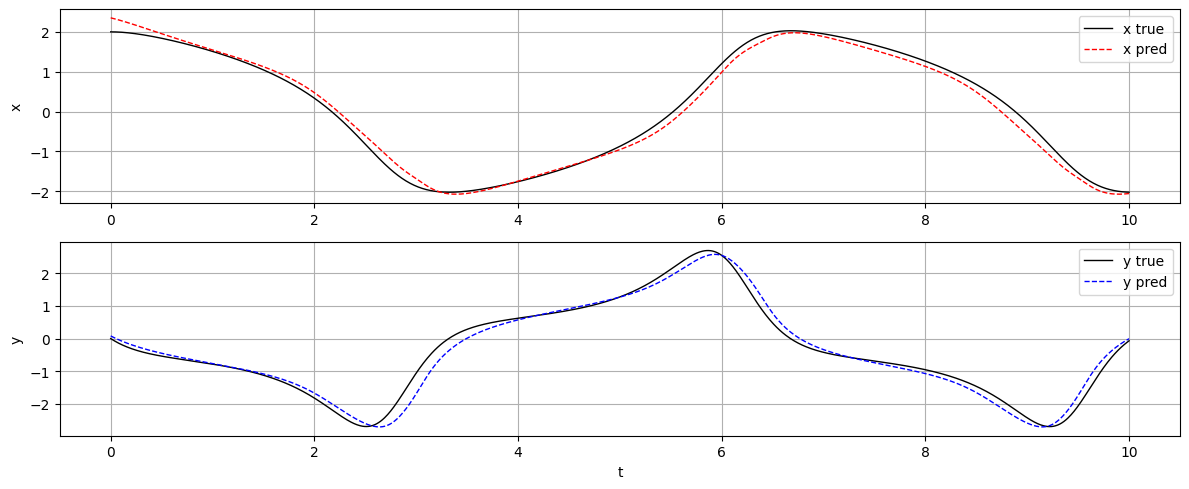

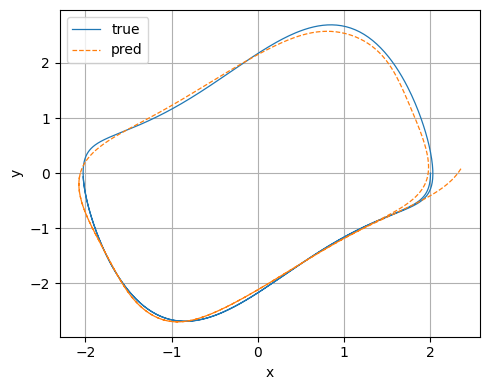

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Data / sampling -----
T = 10.0            # total duration [s]
DT = 0.01           # integration time step [s]
OBS_DT = 0.05       # observation interval [s]
NOISE_STD = 0.2     # std of Gaussian observation noise
SEED = 0            # random seed (reproducibility)

# ----- Model / optimization -----
HIDDEN = 128        # MLP hidden size
LR = 3e-4           # learning rate (AdamW)
WD = 1e-6           # weight decay (L2 regularization)
BATCH = 1024        # batch size
EPOCHS = 1200       # number of training epochs
H_MAX = 12          # max prediction horizon in curriculum (# of OBS_DT steps)


torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)

mu_vdp = 1.0
def vdp_true(u, t):
    x, y = u
    return np.array([y, mu_vdp*(1.0 - x*x)*y - x], dtype=np.float32)

def euler_step_true(f, u, t, h):
    return u + h * f(u, t)

N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float32)
u0 = np.array([2.0, 0.0], dtype=np.float32)

U_true = np.zeros((N, 2), dtype=np.float32)
U_true[0] = u0
for i in range(N-1):
    U_true[i+1] = euler_step_true(vdp_true, U_true[i], t_full[i], DT)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float32)

obs_stride = int(round(OBS_DT / DT))
assert obs_stride >= 1 and abs(obs_stride*DT - OBS_DT) < 1e-9
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]  # (M,2)

# standardization
mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)

w_obs = torch.tensor(Y_obs_std, device=device)
t_rel = torch.tensor(t_obs - t_obs[0], device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], device=device, dtype=torch.long)
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))    # The number of fine steps in each observation interval
assert n_sub >= 1

# f_theta(y)->dy
class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 2)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                nn.init.zeros_(m.bias)
    def forward(self, y, t=None):
        return self.net(y)

@torch.no_grad()
def euler_full_net(f, y0, t_seq):
    y_list = [y0]
    y = y0
    for i in range(len(t_seq)-1):
        h = (t_seq[i+1] - t_seq[i]).to(y.dtype).to(y.device).view(1,1)
        dy = f(y)
        y = y + dy * h
        y_list.append(y)
    return torch.cat(y_list, dim=0)

def euler_steps_batched_net(f, y0_batch, steps_batch, h):

    B = y0_batch.shape[0]
    y = y0_batch
    max_steps = int(steps_batch.max().item())
    h = torch.as_tensor(h, device=y.device, dtype=y.dtype).view(1,1)
    for s in range(max_steps):
        mask = (steps_batch > s).view(B,1)
        if not mask.any(): break
        dy = f(y)
        y = y + dy * h * mask
    return y

model = ODEFunc(hidden=HIDDEN).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.SmoothL1Loss(beta=0.5, reduction='mean')

weight = torch.ones(1,2, device=device)

for ep in range(EPOCHS):
    opt.zero_grad()

    H_curr = min(H_MAX, 1 + ep // 100)

    k_batch = torch.randint(0, M_obs-1, (BATCH,), device=device)
    h_batch = torch.randint(1, H_curr+1, (BATCH,), device=device)
    h_batch = torch.minimum(h_batch, (M_obs-1 - k_batch))

    y0_batch    = w_obs[k_batch]
    y_tar_batch = w_obs[k_batch + h_batch]
    steps_batch = h_batch * n_sub

    y_pred = euler_steps_batched_net(model, y0_batch, steps_batch, DT)

    diff = (y_pred - y_tar_batch) * weight
    loss = loss_fn(diff, torch.zeros_like(diff))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:3d} | loss = {loss.item():.6f} | H_curr = {H_curr}")

with torch.no_grad():
    y0 = w_obs[0:1, :]
    t_seq_std = torch.tensor(t_full, device=device).view(-1,1)
    y_pred_std = euler_full_net(model, y0, t_seq_std)
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()
    Y_true = U_true
    t_plot = t_full

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.plot(t_plot, Y_true[:,0], 'k-', lw=1.0, label='x true')
plt.plot(t_plot, Y_pred[:,0], 'r--', lw=1.0, label='x pred')
plt.ylabel('x'); plt.legend(); plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t_plot, Y_true[:,1], 'k-', lw=1.0, label='y true')
plt.plot(t_plot, Y_pred[:,1], 'b--', lw=1.0, label='y pred')
plt.xlabel('t'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(Y_true[:,0], Y_true[:,1], lw=0.9, label='true')
plt.plot(Y_pred[:,0], Y_pred[:,1], '--', lw=0.9, label='pred')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


Epoch   0 | loss = 0.377028 | H_curr = 3
Epoch 200 | loss = 0.367542 | H_curr = 5
Epoch 400 | loss = 0.345415 | H_curr = 7
Epoch 600 | loss = 0.285355 | H_curr = 9
Epoch 800 | loss = 0.249042 | H_curr = 11
Epoch 1000 | loss = 0.147106 | H_curr = 13


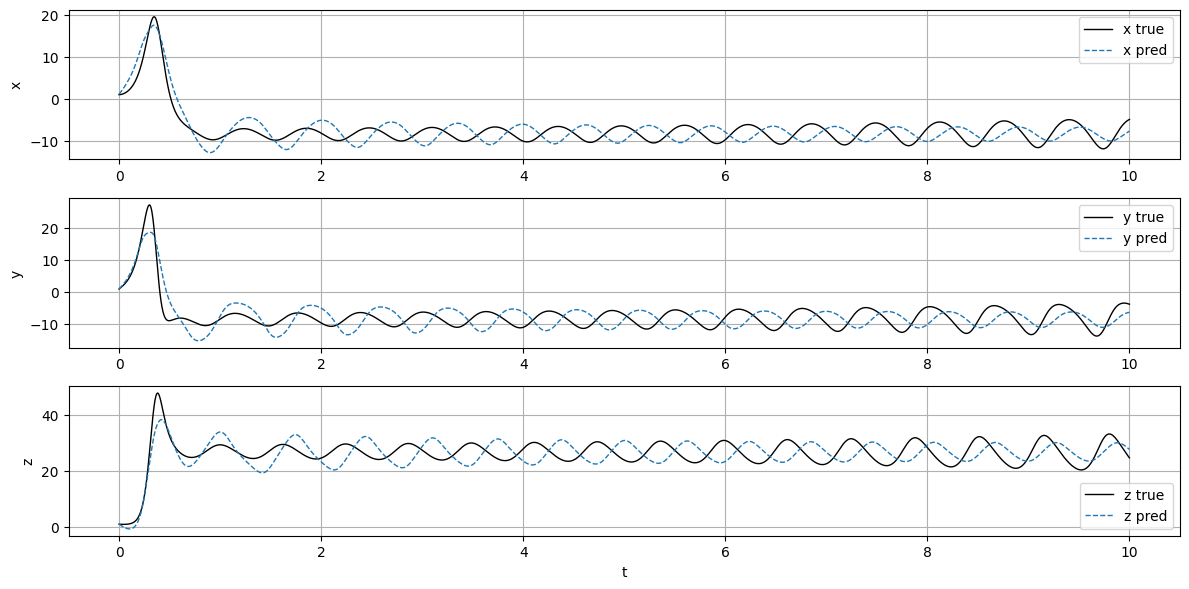

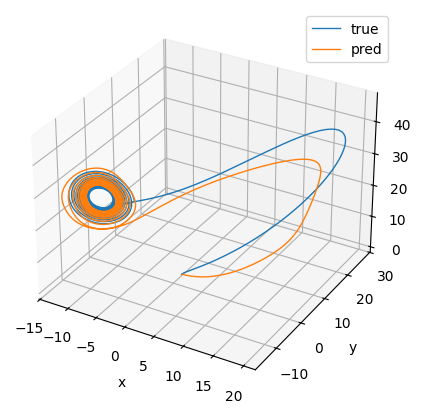

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ----- Data / sampling -----
T = 10.0
DT = 0.005
OBS_DT = 0.025
NOISE_STD = 0.05
SEED = 0

# ----- Model / optimization -----
HIDDEN = 128
LR = 3e-4
WD = 1e-6
BATCH = 1024
EPOCHS = 1200
H_MAX = 20

torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)

# ==== Lorenz System Definition using RK4 ====
def f_np(u, s, b, r):
    x, y, z = u
    return np.array([
        s * (y - x),
        x * (r - z) - y,
        x * y - b * z
    ], dtype=np.float32)

def rk4_np(f, u0, t, dt, *args):
    U = np.zeros((len(t), 3), dtype=np.float32)
    U[0] = u0
    u = u0.copy()
    for i in range(len(t) - 1):
        k1 = f(u, *args)
        k2 = f(u + 0.5 * dt * k1, *args)
        k3 = f(u + 0.5 * dt * k2, *args)
        k4 = f(u + dt * k3, *args)
        u = u + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        U[i+1] = u
    return U

# ==== Generate True & Noisy Data ====
SIGMA_T = 10.0
BETA_T = 8.0 / 3.0
RHO_T = 28.0
u0 = np.array([1.0, 1.0, 1.0], dtype=np.float32)
N = int(T/DT) + 1
t_full = np.linspace(0.0, T, N).astype(np.float32)
U_true = rk4_np(f_np, u0, t_full, DT, SIGMA_T, BETA_T, RHO_T)

U_noisy = U_true + np.random.normal(0, NOISE_STD, size=U_true.shape).astype(np.float32)

obs_stride = int(round(OBS_DT / DT))
obs_idx = np.arange(0, N, obs_stride)
t_obs = t_full[obs_idx]
Y_obs = U_noisy[obs_idx]

# ==== Standardization ====
mu = torch.tensor(U_true.mean(axis=0), device=device)
std = torch.tensor(U_true.std(axis=0) + 1e-8, device=device)

def norm_np(arr): return (arr - mu.cpu().numpy()) / std.cpu().numpy()
def denorm_t(tensor): return tensor * std + mu

Y_obs_std = norm_np(Y_obs)
w_obs = torch.tensor(Y_obs_std, device=device)
t_rel = torch.tensor(t_obs - t_obs[0], device=device)
obs_ofs = torch.tensor(obs_idx - obs_idx[0], device=device, dtype=torch.long)
M_obs = len(obs_idx)

n_sub = int(round(OBS_DT / DT))
assert n_sub >= 1

# ==== Neural ODE Model ====
class ODEFunc(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 3)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.zeros_(m.bias)

    def forward(self, y, t=None):
        return self.net(y)

@torch.no_grad()
def rk4_full_net(f, y0, t_seq):
    y_list = [y0]
    y = y0
    for i in range(len(t_seq) - 1):
        h = (t_seq[i+1] - t_seq[i]).to(y.dtype).to(y.device).view(1,1)
        k1 = f(y)
        k2 = f(y + 0.5 * h * k1)
        k3 = f(y + 0.5 * h * k2)
        k4 = f(y + h * k3)
        y = y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y_list.append(y)
    return torch.cat(y_list, dim=0)

def rk4_steps_batched_net(f, y0_batch, steps_batch, h):
    B = y0_batch.shape[0]
    y = y0_batch
    max_steps = int(steps_batch.max().item())
    h_tensor = torch.tensor(h, device=y.device, dtype=y.dtype).view(1, 1)
    for s in range(max_steps):
        mask = (steps_batch > s).view(B, 1)
        if not mask.any():
            break
        k1 = f(y)
        k2 = f(y + 0.5 * h_tensor * k1)
        k3 = f(y + 0.5 * h_tensor * k2)
        k4 = f(y + h_tensor * k3)
        dy = (1.0 / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y = y + h_tensor * dy * mask
    return y

# ==== Training ====
model = ODEFunc(hidden=HIDDEN).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.MSELoss(reduction='mean')

weight = torch.tensor([[1.0, 1.0, 2.0]], device=device)


for ep in range(EPOCHS):
    opt.zero_grad()
    H_curr = min(H_MAX, 3 + ep // 100)

    k_batch = torch.randint(0, M_obs - H_curr - 1, (BATCH,), device=device)
    h_batch = torch.randint(1, H_curr + 1, (BATCH,), device=device)
    h_batch = torch.minimum(h_batch, (M_obs - 1 - k_batch))

    y0_batch = w_obs[k_batch]
    y_tar_batch = w_obs[k_batch + h_batch]
    steps_batch = h_batch * n_sub

    y_pred = rk4_steps_batched_net(model, y0_batch, steps_batch, DT)
    diff = (y_pred - y_tar_batch) * weight
    loss = loss_fn(diff, torch.zeros_like(diff))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if ep % 200 == 0:
        print(f"Epoch {ep:3d} | loss = {loss.item():.6f} | H_curr = {H_curr}")

# ==== Inference ====
with torch.no_grad():
    y0 = w_obs[0:1, :]
    t_seq_std = torch.tensor(t_full, device=device).view(-1, 1)
    y_pred_std = rk4_full_net(model, y0, t_seq_std)
    Y_pred = denorm_t(y_pred_std.cpu()).numpy()
    Y_true = U_true
    t_plot = t_full

# ==== Visualization ====
plt.figure(figsize=(12, 6))
for i, label in enumerate(['x', 'y', 'z']):
    plt.subplot(3, 1, i+1)
    plt.plot(t_plot, Y_true[:, i], 'k-', lw=1.0, label=f'{label} true')
    plt.plot(t_plot, Y_pred[:, i], '--', lw=1.0, label=f'{label} pred')
    plt.ylabel(label); plt.grid(True); plt.legend()
plt.xlabel('t')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6, 5))
ax = plt.axes(projection='3d')
ax.plot3D(Y_true[:, 0], Y_true[:, 1], Y_true[:, 2], label='true', lw=1)
ax.plot3D(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], label='pred', lw=1)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.legend(); plt.show()
